<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/projrerun/projects/NaturalLanguageProcessing/machine_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Translation

**By Neuromatch Academy**

__Content creators:__ Juan Manuel Rodriguez, Salomey Osei

__Production editors:__ Amita Kapoor, Spiros Chavlis

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Objective

The main goal of this project is to train a sequence to sequence NN that transtlate a language into another language, e.g. french to english. This notebook is based on this [Pytorch tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html), but change several thing. 

---
# Setup

In [1]:
# Imports
import io
import re
import math
import random
import unicodedata

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from tqdm.notebook import tqdm
from sklearn.utils import shuffle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Download the data
import requests, zipfile

zip_file_url = 'https://download.pytorch.org/tutorial/data.zip'
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [3]:
N = 10  # print the 10 first lines
with open('data/eng-fra.txt') as f:
  for i in range(N):
    line = next(f).strip()
    print(line)

Go.	Va !
Run!	Cours !
Run!	Courez !
Wow!	Ça alors !
Fire!	Au feu !
Help!	À l'aide !
Jump.	Saute.
Stop!	Ça suffit !
Stop!	Stop !
Stop!	Arrête-toi !


---
# Representing the data

We create a language representation defining indixes for each word. In addition to the words, our languages have three special tokens:

* SOS: Start Of Sentence
* EOS: End Of Sentence
* PAD: Padding token used to fill inputs vectors where there are no other words.

In [4]:
SOS_token = 0
EOS_token = 1

class Lang:
  def __init__(self, name):
    self.name = name
    self.word2index = {}
    self.word2count = {}
    self.index2word = {0: "SOS", 1: "EOS", 2: "PAD"}
    self.n_words = 3  # Count SOS and EOS and PAD

  def addSentence(self, sentence):
    for word in sentence.split(' '):
      self.addWord(word)

  def addWord(self, word):
    if word not in self.word2index:
      self.word2index[word] = self.n_words
      self.word2count[word] = 1
      self.index2word[self.n_words] = word
      self.n_words += 1
    else:
      self.word2count[word] += 1


def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
  )


def normalizeString(s):
  s = unicodeToAscii(s.lower().strip())
  s = re.sub(r"([.!?])", r" \1", s)
  s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
  return s


def readLangs(lang1, lang2, reverse=False):
  print("Reading lines...")

  # Read the file and split into lines
  lines = io.open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
      read().strip().split('\n')

  # Split every line into pairs and normalize
  pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

  # Reverse pairs, make Lang instances
  if reverse:
      pairs = [list(reversed(p)) for p in pairs]
      input_lang = Lang(lang2)
      output_lang = Lang(lang1)
  else:
      input_lang = Lang(lang1)
      output_lang = Lang(lang2)

  return input_lang, output_lang, pairs

In [5]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
  return len(p[0].split(' ')) < MAX_LENGTH and \
      len(p[1].split(' ')) < MAX_LENGTH and \
      p[1].startswith(eng_prefixes)


def filterPairs(pairs):
  return [pair for pair in pairs if filterPair(pair)]

In [6]:
def prepareData(lang1, lang2, reverse=False):
  input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
  print("Read %s sentence pairs" % len(pairs))
  pairs = filterPairs(pairs)
  print("Trimmed to %s sentence pairs" % len(pairs))
  print("Counting words...")
  for pair in pairs:
    input_lang.addSentence(pair[0])
    output_lang.addSentence(pair[1])
  print("Counted words:")
  print(input_lang.name, input_lang.n_words)
  print(output_lang.name, output_lang.n_words)
  return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4346
eng 2804
['nous sommes sans emploi .', 'we re unemployed .']


## Language word distributions

We can check which is the word distribution in our dataset.

In [7]:
def plot_lang(lang, top_k=100):
  words = list(lang.word2count.keys())
  words.sort(key=lambda w: lang.word2count[w], reverse=True)
  print(words[:top_k])
  count_occurences = sum(lang.word2count.values())

  accumulated = 0
  counter = 0

  while accumulated < count_occurences * 0.8:
    accumulated += lang.word2count[words[counter]]
    counter += 1

  print(f"The {counter * 100 / len(words)}% most common words "
        f"account for the {accumulated * 100 / count_occurences}% of the occurrences")
  plt.bar(range(100), [lang.word2count[w] for w in words[:top_k]])
  plt.show()

['.', 'je', 'suis', 'est', 'vous', 'pas', 'de', 'il', 'nous', 'tu', 'etes', 'ne', 'es', 'en', 'a', 'n', 'un', 'sommes', 'elle', 'la', 'tres', 'c', 'que', 'le', 'sont', 'j', 'une', 'd', 'ai', 'pour', 'l', 'ils', 'plus', 'ce', 'des', 'me', 'vais', 'elles', 'moi', '!', 'mon', 'trop', 'train', 'fort', 'si', 'ici', 'du', 'toujours', 'toi', 'tout', 'tous', 'les', '?', 'vraiment', 'sur', 't', 'te', 'm', 'dans', 'avec', 'avoir', 'encore', 'qu', 'tom', 'votre', 'au', 'peur', 'y', 'desole', 'bien', 'ca', 'bon', 'fais', 'toutes', 'heureux', 'faire', 'etre', 'son', 'aussi', 'assez', 'lui', 'tellement', 'ma', 'mes', 'fatigue', 'par', 'et', 'fait', 'ton', 'se', 'juste', 'maintenant', 'grand', 'desolee', 'avons', 'allons', 'peu', 'deux', 'on', 'vieux']
The 4.674188349067465% most common words account for the 80.0371543427945% of the occurrences


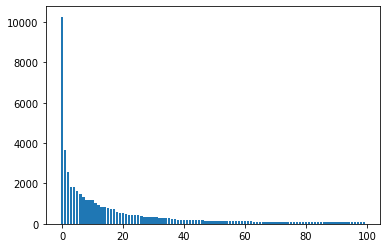

In [8]:
plot_lang(input_lang)

['.', 'i', 're', 'you', 'm', 'he', 'not', 'is', 'a', 'to', 'we', 's', 'the', 'very', 'are', 'of', 'she', 'am', 'they', 'in', 'going', 'my', 'for', 'all', 'at', 'here', 'with', 'that', 'good', 'as', 'your', 't', 'me', 'too', 'this', 'sorry', 'on', 'glad', 'it', 'than', 'now', 'happy', 'about', '?', 'aren', 'so', 'tired', 'afraid', 'sure', 'right', 'an', 'his', 'out', 'really', 'one', 'busy', 'still', 'just', 'old', 'always', 'tom', 'looking', 'be', 'friend', 'no', 'her', 'ready', 'by', '!', 'and', 'teacher', 'from', 'getting', 'him', 'alone', 'being', 'home', 'up', 'have', 'go', 'doing', 'help', 'see', 'proud', 'man', 'married', 'kind', 'who', 'waiting', 'yet', 'young', 'person', 'done', 'late', 'friends', 'new', 'anymore', 'hungry', 'such', 'sick']
The 4.85540878257765% most common words account for the 80.00500226665207% of the occurrences


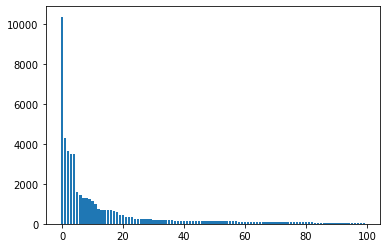

In [9]:
plot_lang(output_lang)

## The RNN

Our goal is to create a network that takes an input sentence in one language and then provides the translation of the sentence in an output language.  Our network will use an RNN which will consist of an encoder, and a decoder. The encoder will first transform our input sentence into a vector, and pass this condensed vector into the decoder which will then translate the text in our given language. The process of this is further explained in the diagram below:

<img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/projects/static/seq2seq.png" width="600" height="300">

**Note:** Please note that this same approach can be used for next sentence prediction task

In [10]:
class EncoderRNN(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(EncoderRNN, self).__init__()
    self.hidden_size = hidden_size

    self.embedding = nn.Embedding(input_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

  def forward(self, input, hidden):
    embedded = self.embedding(input)#.view(1, 1, -1)
    output = embedded
    output, hidden = self.gru(output, hidden)
    return output, hidden

  def initHidden(self, batch_size):
    return torch.zeros(1, batch_size, self.hidden_size, device=device)

In [11]:
class DecoderRNN(nn.Module):
  def __init__(self, hidden_size, output_size):
    super(DecoderRNN, self).__init__()
    self.hidden_size = hidden_size

    self.embedding = nn.Embedding(output_size, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
    self.out = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=-1)

  def forward(self, input, hidden):
    output = self.embedding(input)
    output = F.relu(output)
    output, hidden = self.gru(output, hidden)
    output = self.softmax(self.out(output))
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, 1, self.hidden_size, device=device)

---
# Representing the text


In [12]:
def to_train(input_lang, output_lang, pairs, max_len=MAX_LENGTH+2):
  x_input = []
  x_output = []
  target = []
  for i, o in pairs:
    s_i = [2] * max_len + [0] + [input_lang.word2index[w] for w in i.split(" ")] + [1]
    s_o = [0] + [output_lang.word2index[w] for w in o.split(" ")] + [1] + [2] * max_len
    s_to = s_o[1:] + [2]
    x_input.append(s_i[-max_len:])
    x_output.append(s_o[:max_len])
    target.append(s_to[:max_len])
  return x_input, x_output, target

In [13]:
x_input, x_partial, y = to_train(input_lang, output_lang, pairs)

In [14]:
print('Representation of an input sentece:')
print(x_input[0])
print(' '.join([input_lang.index2word[w] for w in x_input[0]]))
print('\nRepresentation of an partial sentece:')
print(x_partial[0])
print(' '.join([output_lang.index2word[w] for w in x_partial[0]]))
print('\nRepresentation of an target sentece:')
print(y[0])
print(' '.join([output_lang.index2word[w] for w in y[0]]))

Representation of an input sentece:
[2, 2, 2, 2, 2, 2, 0, 3, 4, 5, 6, 1]
PAD PAD PAD PAD PAD PAD SOS j ai ans . EOS

Representation of an partial sentece:
[0, 3, 4, 5, 1, 2, 2, 2, 2, 2, 2, 2]
SOS i m . EOS PAD PAD PAD PAD PAD PAD PAD

Representation of an target sentece:
[3, 4, 5, 1, 2, 2, 2, 2, 2, 2, 2, 2]
i m . EOS PAD PAD PAD PAD PAD PAD PAD PAD


We represent the input sentence using left padding because the GRU network process the sentence left to rignt, and we want that the output is as close to our sentence as possible. In contrast, we use right padding to the partial translation sentence because we want that our context is process inmediatly by our decoder. Finally, our target is our partial translation left-shifted.

## Training
Using this representation, we can train our model. Notice that our feed the full sentences as partial translations instanted of feeding partial sentences. This speed-ups our training, as next words in the sentence do not affects the output of the network and the gradients up to that point. 

In [15]:
def predict(encoder, decoder, input, output):
  _, hidden = encoder(input, encoder.initHidden(input.shape[0]))
  out, _ = decoder(output, hidden)
  return out

def train(encoder, decoder, loss, input, output, target, learning_rate=0.001, epochs=10, batch_size=100):

  plot_losses = []
  plot_full_losses = []

  encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
  decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

  for _ in tqdm(range(epochs)):
    c_input, c_output, c_target = shuffle(input, output, target)
    c_input = torch.tensor(c_input, dtype=torch.long, device=device)
    c_output = torch.tensor(c_output, dtype=torch.long, device=device)
    c_target = torch.tensor(c_target, dtype=torch.long, device=device)
    acc_loss = 0
    for i in range(0, c_target.shape[0], batch_size):
      c_batch_size = c_target[i:i+batch_size, ...].shape[0]
      encoder_optimizer.zero_grad()
      decoder_optimizer.zero_grad()

      out = predict(encoder, decoder, c_input[i:i+batch_size, ...], c_output[i:i+batch_size, ...])
      #Reshapes the output and target to use the expected loss format.
      # N x Classes for the output
      # N for the targets
      # Where N is the batch size
      out = out.reshape(c_batch_size * c_input.shape[1], -1)
      r_target = c_target[i:i+batch_size, ...].reshape(c_batch_size * c_input.shape[1])

      c_loss = loss(out, r_target)
      # Mask the errors for padding as they are not usefull!
      valid = torch.where(r_target == 2, 0, 1)
      c_loss = c_loss * valid
      c_loss = torch.sum(c_loss) #/ torch.sum(valid)

      c_loss.backward()

      encoder_optimizer.step()
      decoder_optimizer.step()
      plot_full_losses.append(c_loss.detach().numpy())
      acc_loss += c_loss.detach().numpy()
    plot_losses.append(acc_loss /math.ceil(c_target.shape[0] / batch_size))
  return plot_losses, plot_full_losses

In [16]:
hidden_size = 300
num_epochs = 10  # Change this to 50 (original value!)
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words)
epoch_error, batch_error = train(encoder, decoder,
                                 nn.NLLLoss(reduction='none'),
                                 x_input, x_partial, y,
                                 epochs=num_epochs)

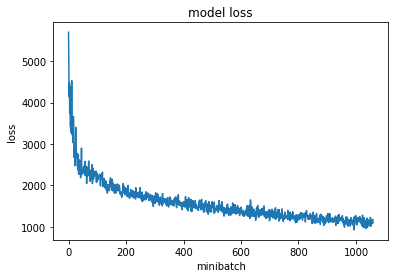

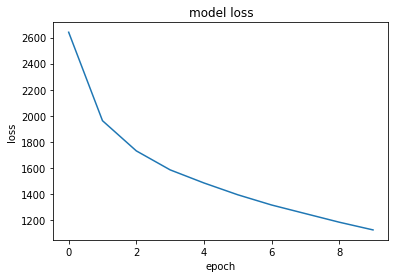

In [17]:
#print(epoch_error)
#print(batch_error)

plt.plot(batch_error)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('minibatch')
plt.show()

plt.plot(epoch_error)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

---
# Prediction and generation

In the following cells, we can can see how our Seq2Seq model produces a prediction.

In [18]:
p = predict(encoder, decoder, torch.tensor([x_input[40]],
                                           dtype=torch.long,
                                           device=device),
            torch.tensor([x_partial[40]], dtype=torch.long, device=device))

p = p.detach().numpy()

In [19]:
print(np.argmax(p, axis=-1))
print(x_partial[40])

[[  3   4 103   5   1   5   5   5   5   5   5   5]]
[0, 3, 4, 32, 5, 1, 2, 2, 2, 2, 2, 2]


---
# Generating a translation

The generation is a very simple iterative process:

1. Initialize the partiar translation using only the start of sentence token '
SOS' (its id, which is 0).
1. Repeat:
    1. Predict the probability distribution for the next token given the partial translation.
    1. Pick the most probable token. (other option is to sample the distribution).
    1. Add that token to the translation.
    1. If the token is EOF, break the loop.
1. Return the partial translation, which is now a full translation.

If we want to generate several candidates, we can use other generation algorithm. [Beam Search](https://www.youtube.com/watch?v=RLWuzLLSIgw) is a great option for this.

In [20]:
def gen_translation(encoder, decoder, text, input_lang, output_lang,
                    max_len=MAX_LENGTH+2):

  text =  [2] * max_len + [0] + [input_lang.word2index[w] for w in text.split(" ")] + [1]
  text = torch.tensor([text[-max_len:]], dtype=torch.long, device=device)
  out = [0] + [2] * max_len
  out = [out[:max_len]]
  for i in range(1, max_len):
    pt_out =torch.tensor(out, dtype=torch.long, device=device)
    p = predict(encoder, decoder, text, pt_out).detach().numpy()
    out[0][i] = np.argmax(p, axis=-1)[0, i-1]
    if np.argmax(p, axis=-1)[0, i-1] == 1:
      break

  return ' '.join([output_lang.index2word[idx] for idx in out[0]])

In [21]:
gen_translation(encoder, decoder, pairs[40][0], input_lang, output_lang)

'SOS i m in trouble . EOS PAD PAD PAD PAD PAD'

In [22]:
for i in range(40):
  print('> {}'.format(pairs[i][0]))
  print('= {}'.format(pairs[i][1]))
  print('< {}'.format(gen_translation(encoder, decoder,
                                      pairs[i][0],
                                      input_lang,
                                      output_lang)))
  print('*' * 40)

> j ai ans .
= i m .
< SOS i m really . EOS PAD PAD PAD PAD PAD PAD
****************************************
> je vais bien .
= i m ok .
< SOS i m going to go . EOS PAD PAD PAD PAD
****************************************
> ca va .
= i m ok .
< SOS i m going to go . EOS PAD PAD PAD PAD
****************************************
> je suis gras .
= i m fat .
< SOS i m exhausted . EOS PAD PAD PAD PAD PAD PAD
****************************************
> je suis gros .
= i m fat .
< SOS i m exhausted . EOS PAD PAD PAD PAD PAD PAD
****************************************
> je suis en forme .
= i m fit .
< SOS i m in trouble . EOS PAD PAD PAD PAD PAD
****************************************
> je suis touche !
= i m hit !
< SOS i m so ! EOS PAD PAD PAD PAD PAD PAD
****************************************
> je suis touchee !
= i m hit !
< SOS i m so ! EOS PAD PAD PAD PAD PAD PAD
****************************************
> je suis malade .
= i m ill .
< SOS i m a teacher . EOS PAD PAD PAD PAD PAD
***

In [23]:
for i in range(40):
  print('> {}'.format(pairs[-i][0]))
  print('= {}'.format(pairs[-i][1]))
  print('< {}'.format(gen_translation(encoder, decoder,
                                      pairs[-i][0],
                                      input_lang,
                                      output_lang)))
  print('*' * 40)

> j ai ans .
= i m .
< SOS i m really . EOS PAD PAD PAD PAD PAD PAD
****************************************
> il est un des candidats aux presidentielles americaines .
= he is one of the american presidential candidates .
< SOS he is a good at the mood . EOS PAD PAD
****************************************
> ils collectent des dons pour l eglise .
= they are collecting contributions for the church .
< SOS they are in the same age . EOS PAD PAD PAD
****************************************
> j ai quelques difficultes a compiler ce programme .
= i m having some problems compiling this software .
< SOS i m going to go out of this . EOS PAD
****************************************
> il entreprend des experiences dans son laboratoire .
= he is carrying out experiments in his laboratory .
< SOS he is afraid of his success . EOS PAD PAD PAD
****************************************
> elle est non seulement belle mais aussi intelligente .
= she is not only beautiful but also intelligent .
< SOS

---
# To dos

1. We use the full dataset to train/test. This is not a great idea, you should split the dataset into training/test.
2. We did some empirical evaluation looking at the translated senteces. Other evaluation can be done using metrics like [BLUE](https://www.nltk.org/api/nltk.translate.html?highlight=bleu_score#module-nltk.translate.bleu_score) score.
3. We try it with languages that are writting in a left-rigth as input and output. What happens if the languages are not written in this way? [Datasets](https://www.manythings.org/anki/) [Even more](https://tatoeba.org/en/downloads) 
4. It would be possible to do machine translation using other NN architectures, such as attention based model. 
5. We are not handling proper nouns, and that could be a problem.
6. This can be applied to next sentence prediction.

---
# Further reading
* [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215)

* [Neural machine translation by jointly learning to align and translate](https://arxiv.org/abs/1409.0473)

* [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025)